In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
print(sys.executable)

E:\anaconda\python.exe


In [4]:
import sys
!{sys.executable} -m pip install wordcloud

In [47]:
%matplotlib inline

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK datasets
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Set seaborn style
sns.set(style="whitegrid")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vichu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\vichu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vichu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vichu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vichu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [78]:
# Load only 700 rows to avoid memory errors
df = pd.read_csv('consumer_complaints.csv', nrows=5000, low_memory=False)

# Show column names
df.columns.tolist()

['Date received',
 'Product',
 'Sub-product',
 'Issue',
 'Sub-issue',
 'Consumer complaint narrative',
 'Company public response',
 'Company',
 'State',
 'ZIP code',
 'Tags',
 'Consumer consent provided?',
 'Submitted via',
 'Date sent to company',
 'Company response to consumer',
 'Timely response?',
 'Consumer disputed?',
 'Complaint ID']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date received                 5000 non-null   object
 1   Product                       5000 non-null   object
 2   Sub-product                   4998 non-null   object
 3   Issue                         5000 non-null   object
 4   Sub-issue                     4903 non-null   object
 5   Consumer complaint narrative  208 non-null    object
 6   Company public response       334 non-null    object
 7   Company                       5000 non-null   object
 8   State                         4989 non-null   object
 9   ZIP code                      4999 non-null   object
 10  Tags                          120 non-null    object
 11  Consumer consent provided?    483 non-null    object
 12  Submitted via                 5000 non-null   object
 13  Date sent to compa

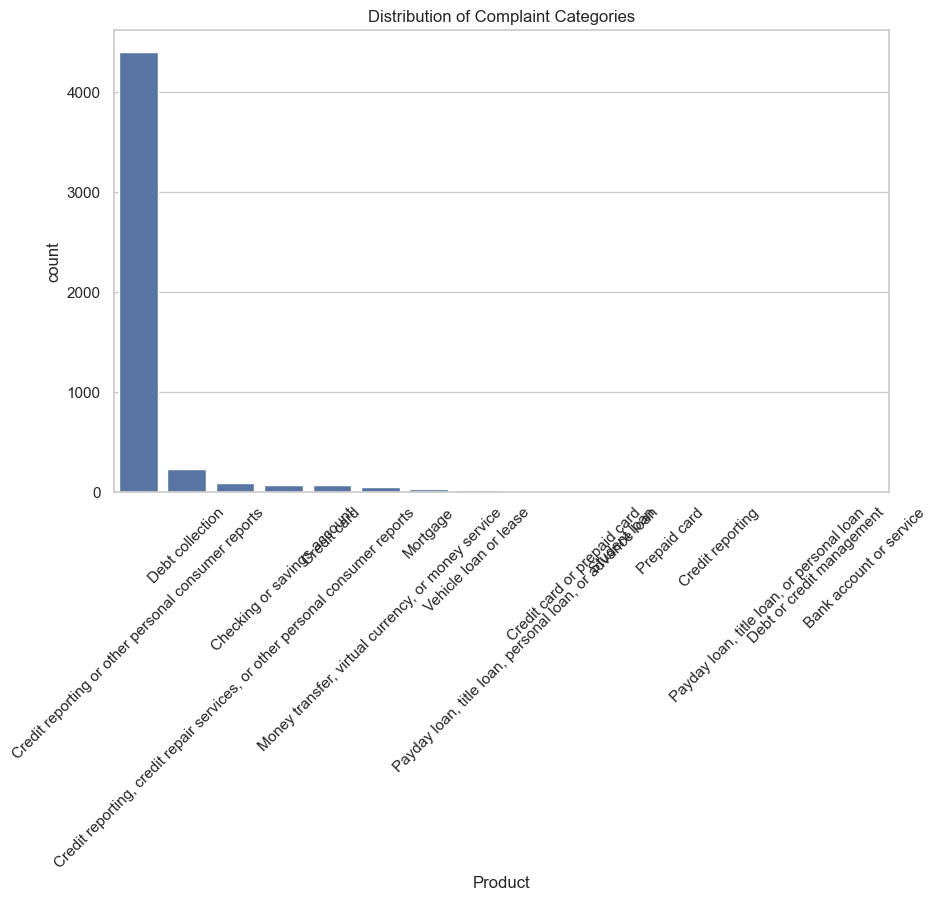

In [79]:
# Quick overview
df.info()
print("\nMissing values per column:\n", df.isnull().sum())

# Basic distribution
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Product', order=df['Product'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribution of Complaint Categories')
plt.show()

In [80]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Normalize column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Preprocessing function
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

# Apply preprocessing
df['cleaned_narrative'] = df['consumer_complaint_narrative'].apply(preprocess_text)
df[['product', 'cleaned_narrative']].head()

,product,cleaned_narrative
0,"Credit reporting, credit repair services, or o...",
1,Credit reporting or other personal consumer re...,
2,Credit reporting or other personal consumer re...,
3,Credit reporting or other personal consumer re...,
4,Credit reporting or other personal consumer re...,


In [81]:
print("Total rows before filtering:", len(df))
print("\nUnique Product Categories:")
print(df['product'].unique())
print("\nNon-empty cleaned narratives:", df['cleaned_narrative'].str.strip().ne('').sum())

Total rows before filtering: 5000

Unique Product Categories:
['Credit reporting, credit repair services, or other personal consumer reports'
 'Credit reporting or other personal consumer reports'
 'Payday loan, title loan, personal loan, or advance loan'
 'Debt collection' 'Checking or savings account'
 'Credit card or prepaid card' 'Credit card' 'Mortgage' 'Prepaid card'
 'Vehicle loan or lease'
 'Money transfer, virtual currency, or money service' 'Student loan'
 'Credit reporting' 'Debt or credit management'
 'Payday loan, title loan, or personal loan' 'Bank account or service']

Non-empty cleaned narratives: 208


In [82]:
# Define mapping
category_map = {
    'Credit reporting, credit repair services, or other personal consumer reports': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}

# Apply mapping
df['label'] = df['product'].map(category_map)

# Filter valid rows
df = df[df['label'].notna() & df['cleaned_narrative'].str.strip().ne('')]

print("Rows after mapping:", len(df))
print(df['label'].value_counts())

Rows after mapping: 71
label
0.0    36
1.0    26
3.0     9
Name: count, dtype: int64


In [83]:
X = df['cleaned_narrative']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Training samples: 56
Testing samples: 15


In [84]:
# Convert text to numerical features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("TF-IDF training shape:", X_train_vec.shape)

TF-IDF training shape: (56, 1172)


In [85]:
print("Unique labels in y_train:", y_train.unique())
print("Label counts in full dataset:")
df['product'].value_counts().head(20)

Unique labels in y_train: [0. 1. 3.]
Label counts in full dataset:


product
Credit reporting, credit repair services, or other personal consumer reports    36
Debt collection                                                                 26
Mortgage                                                                         9
Name: count, dtype: int64

In [86]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n--- {name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))


--- Logistic Regression ---
Accuracy: 0.6667
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         8
         1.0       0.67      0.40      0.50         5
         3.0       0.00      0.00      0.00         2

    accuracy                           0.67        15
   macro avg       0.44      0.47      0.43        15
weighted avg       0.58      0.67      0.59        15


--- SVM ---
Accuracy: 0.6000
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73         8
         1.0       1.00      0.20      0.33         5
         3.0       0.00      0.00      0.00         2

    accuracy                           0.60        15
   macro avg       0.52      0.40      0.35        15
weighted avg       0.64      0.60      0.50        15


--- Naive Bayes ---
Accuracy: 0.6000
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73         8
         1.0   

E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: Undefine


--- Random Forest ---
Accuracy: 0.6000
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73         8
         1.0       1.00      0.20      0.33         5
         3.0       0.00      0.00      0.00         2

    accuracy                           0.60        15
   macro avg       0.52      0.40      0.35        15
weighted avg       0.64      0.60      0.50        15



E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


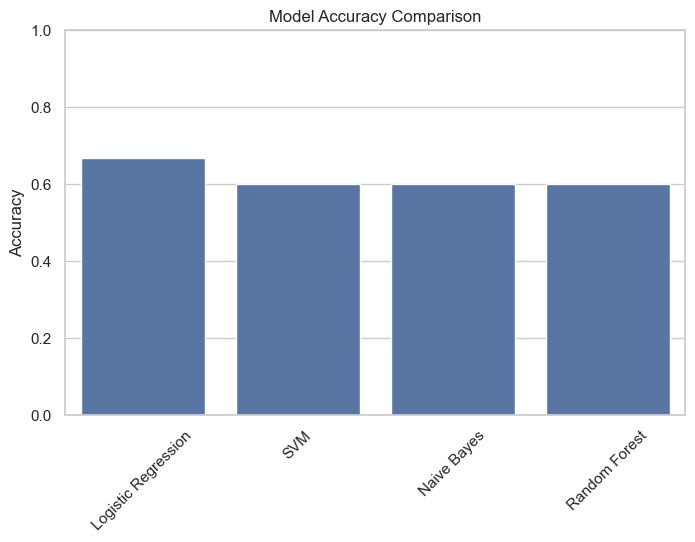

In [87]:
plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

In [88]:
# Choose best-performing model (adjust based on results above)
best_model = RandomForestClassifier(n_estimators=100)
best_model.fit(X_train_vec, y_train)

# Inverse label map
inv_map = {v: k for k, v in category_map.items()}

# Define prediction function
def predict_category(complaint):
    complaint_clean = preprocess_text(complaint)
    vec = vectorizer.transform([complaint_clean])
    pred = best_model.predict(vec)[0]
    return inv_map[pred]

# Test example
sample_complaint = "I was charged an unexpected fee on my credit card."
print("Predicted Category:", predict_category(sample_complaint))

Predicted Category: Credit reporting, credit repair services, or other personal consumer reports
